# How cool is cucumber? Experiments with word embedding

We all know old, good and hackneyed examples, that are typically used to intuitively explain, what the **word embedding** technique is. We almost always come across a chart presenting a simplified, 2-dimensional vector representation of words **queen** and **king**, which are distant from each other in the similar length as words **woman** and **man**. 

One of the most convenient ways to get **embedding vectors** for natural language is to use pre-trained models distributed with [**spacy**](https://spacy.io/) library.

In [4]:
import numpy as np
import numpy.typing as npt
import spacy
import matplotlib.pyplot as plt

In [5]:
# Installing en_core_web_mdn
nlp = spacy.load('en_core_web_md')

In [6]:
fire = nlp('fire')
ice = nlp('ice')

In [7]:
len(fire.vector)

300

A couple of simple function calls, but there is a lot work done behind the scene. In fact, we can use **nlp** object to process whole sentences (or documents) at once. For now, we only need to process single words.

## Math behind

### Adding a new axis

The experiment I'd like to conduct is to "draw" a straight line in n-dimensional space and treat it as a new axis. It's possible if we project the considered points on this line.

We also will use a **midpoint** between two initial points as beginining of our new axis.
It can be calculated with the following formula:

<center>
$  M = (\frac{x + x_{1}}{2}, \frac{y + y_{1}}{2}, \frac{z + z_{1}}{2}, ...) $
</center>

Writing that as a function:

In [8]:
def midpoint(x: npt.NDArray, y: npt.NDArray) -> npt.NDArray:
    if (len(x) != len(y)):
        raise ValueError(
            f'Vectors come from different spaces! ' + 
            f'x: {len(x)} dimensions, y: {len(y)} dimensions')
    return (x + y) / 2

In [9]:
# midpoint(np.array([2, 3]), np.array([-1, 20]))
# midpoint(np.array([2, 3]), np.array([-1, 20, -45]))

In [10]:
mid = midpoint(fire.vector, ice.vector)

Two values that we need for the moment:
* ```mid```
* ```direction```

### Plotting function

In [13]:
def plot(points, lines, labels):
    points_x = [x[0] for x in points]
    points_y = [x[1] for x in points]
    
    # Lines
    for l in lines:
        plt.plot([l[0][0], l[1][0]], [l[0][1], l[1][1]])
    
    # Labels
    for coords, lbl in zip(points, labels):
        plt.text(coords[0], coords[1], lbl)
    
    # Points
    plt.plot(points_x, points_y, '.')
    plt.grid()
    plt.axhline(linewidth=1, color='black')
    plt.axvline(linewidth=1, color='black')
    plt.axis('equal')
    plt.show()

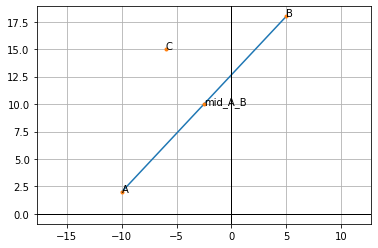

In [15]:
# Points lying on the straight line
A = np.array([-10, 2])
B = np.array([5, 18]) # 18

# a = np.array([2, 2])
# b = np.array([-2, -2])

M = midpoint(a, b)

C = np.array([-6, 15])

points = [A, B, M, C]
lines  = [[A, B]]
labels = ['A', 'B', 'mid_A_B', 'C']

plot(points, lines, labels)

As we can see, the line doesn't pass trough the origin. We have to apply **affine transformation** to shift the whole space, placing **midpoint AB** at (0, 0). If we do so, we can easily find orthogonal projection of the point C on the line spanned by the **B vector**. We can call it **B vector**, because after we shift the space, the segment $|MB|$ becomes a vector as it has its start in the origin.

In [16]:
transform_matrix = np.eye(3)
transform_matrix[0:2, -1] = -M
transform_matrix

array([[  1. ,   0. ,   2.5],
       [  0. ,   1. , -10. ],
       [  0. ,   0. ,   1. ]])

If you'd like to know more details, how to construct the transformation matrix, see for example [Affine Transformation Matrices](https://articulatedrobotics.xyz/5-transformation_matrices/).

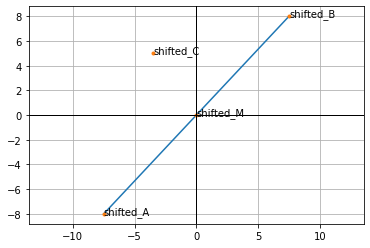

In [18]:
# tranformed_a = affine_transform_matrix @ np.vstack(a.T, [1])
def extend_with_one(vec):
    vec = vec[np.newaxis].T
    return np.vstack([vec, [1]])  

transposed  = [extend_with_one(p) for p in points]
transformed = [transform_matrix @ vec for vec in transposed]
# Removing last dimension with '1'
transformed = [vec[0:2] for vec in transformed]
aff_A, aff_B, aff_M, aff_C = transformed

lines  = [[aff_A, aff_B]]
labels = ['shifted_A', 'shifted_B', 'shifted_M', 'shifted_C']

plot(transformed, lines, labels)

### Projection

In [21]:
dir_vec = (aff_B) / np.linalg.norm(aff_B)
proj_C = (aff_C.T @ dir_vec) / (dir_vec.T @ dir_vec) * dir_vec
proj_C

array([[0.85758836],
       [0.91476091]])

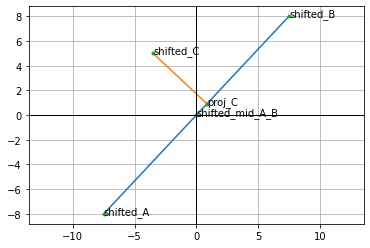

In [25]:
# Plot 
points = transformed + [proj_c]
lines  = [[aff_A, aff_B], [aff_C, proj_C]]
labels = ['shifted_A', 'shifted_B', 'shifted_mid_A_B', 'shifted_C', 'proj_C']
plot(points, lines, labels)

In [28]:
dist = np.linalg.norm(proj_C)
dist_to_A = np.linalg.norm(proj_C - aff_A)
dist_to_B = np.linalg.norm(proj_C - aff_B)
sign = 1 if dist_to_B < dist_to_A else -1
value = sign * dist
value

1.2538920696157714

## Axis class

Rewriting all as a function

In [57]:
# Nie działa
class axis:
    
    def __init__(self, negative_pole, positive_pole):
        
        self.dims = len(negative_pole)
        
        self.A = negative_pole 
        self.B = positive_pole
        self.M = midpoint(negative_pole, positive_pole)
        self.transform = self.transformation_matrix(M)
        
        # Transformation
        self.shifted_A = self.shift(A)
        self.shifted_B = self.shift(B)
        
        self.direction = self.shifted_B / np.linalg.norm(self.shifted_B)
        # shifted_M is (0, 0, ...)
    
    def extend_with_one(self, V):
        V = V[np.newaxis].T
        return np.vstack([V, [1]])      
    
    def transformation_matrix(self, M):
        mat = np.eye(self.dims + 1)
        mat[0:self.dims, -1] = -M
        return mat   
    
    def shift(self, V):
        return (self.transform @ self.extend_with_one(V))[0:self.dims]
    
    def project(self, V):
        shifted_V = self.shift(V)
        return (V.T @ self.direction) / (self.direction.T @ self.direction) * self.direction
   
    def __call__(self, V):
        proj_V = self.project(V)
        dist = np.linalg.norm(proj_V)
        dist_to_A = np.linalg.norm(proj_V - self.shifted_A)
        dist_to_B = np.linalg.norm(proj_V - self.shifted_B)
        sign = 1 if dist_to_B < dist_to_A else -1
        value = sign * dist
        return value

In [58]:
## Simplified example in 2-dimensional space

In [59]:
# To discover potential bugs in the code we've written, 
# we make a simple experiment using a comprehensible example in 2-dimensional space.

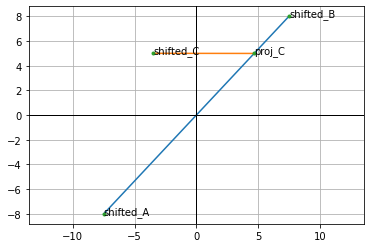

In [73]:
# Points lying on the straight line

A = np.array([-10, 2])
B = np.array([5, 18]) # 18

C = np.array([-6, 15])


axis_a_b = axis(A, B)

# C = np.array([4, 8])

proj_C = axis_a_b.project(C)

points = [axis_a_b.shift(A), axis_a_b.shift(B), axis_a_b.shift(C), proj_C]
shifted_A, shifted_B, shifted_C, _ = points

lines  = [[shifted_A, shifted_B], [shifted_C, proj_C]]
labels = ['shifted_A', 'shifted_B', 'shifted_C', 'proj_C']
plot(points, lines, labels)

## Experiment with embeddings

In [75]:
ice_fire_axis = axis(ice.vector, fire.vector)

In [29]:
# Ice
ice_fire_axis.pole_x

# Fire
ice_fire_axis.pole_y

-4.104704

In [30]:
ice_fire_axis(nlp('icecream').vector)

1.5802484

In [31]:
ice_fire_axis(nlp('polar').vector)

1.3376285

In [32]:
axis(np.array([1, 2]), np.array([10, 2])).project(np.array([4, 5]))

array([4., 2.])

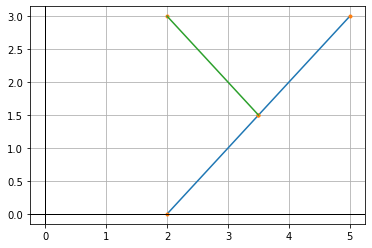

array([3.5, 1.5])

In [34]:
# a = np.array([1, 2])
# b = np.array([10, 2])
# c = np.array([4, 5])

a = np.array([2, 0])
b = np.array([5, 3])
c = np.array([2, 3])

line_a_b = axis(a, b)
mid_a_b = line_a_b.mid


proj_c = line_a_b.project(c)

points = [a, b, mid_a_b, c, proj_c]

points_x = [x[0] for x in points]
points_y = [x[1] for x in points]


plt.plot([a[0], b[0]], [a[1], b[1]])
plt.plot(points_x, points_y, '.')
# Line
plt.plot([c[0], proj_c[0]], [c[1], proj_c[1]], '-')
plt.grid()
plt.axhline(linewidth=1, color='black')
plt.axvline(linewidth=1, color='black')
plt.show()

proj_c

In [35]:
line_a_b.direction

array([-0.70710678, -0.70710678])

In [36]:
line_a_b.x - line_a_b.mid

array([-1.5, -1.5])

In [37]:
line_a_b.x 

array([2, 0])